# Wide binaries with hidden tertiaries

In [188]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

from binaryStatistics.base_distribution import BaseDistribution
from binaryStatistics.distributions import Uniform, Thermal, PowerLaw, Sine, VelTilde, PhiAngle, Log
from binaryStatistics.plot_utils import plot_histogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
def power_law(x: float or np.array, C: float, alpha: float) -> np.array:
    """Power law fit.
    
    Parameters:
        x (float or np.array):
            The X independent data to fit.
        
        C (float):
            Proportionality constant.
        
        alpha (float):
            Power-law exponent
        
    Returns:
        The fitted Y dependent data.
    """
    return C * np.power(x, -alpha)

In [456]:
# Function for simulate hidden companion mass
def get_companions_mass(Mag1, Mag2, label="without"):
    
    def get_kappa(delta_Mag):
        dM = delta_Mag.random_sample(29,30,1)
        return 1/(1 + 10**(-0.4*dM))[0]
    
    def get_mass(mag):
        return 10**(0.0725*(4.76 - mag))
    
    gamma = -0.6
    delta_Mag = PowerLaw(
        dist_parameters={
            "C": (1 + gamma)/(12**gamma),
            "alpha": gamma,
        }
    )
    kappa = get_kappa(delta_Mag)
    
    if label == "without":
        return {
            "mass_A_1": get_mass(Mag1),
            "mass_A_2": 0.0,
            "mass_B_1": get_mass(Mag2),
            "mass_B_2": 0.0,
        }
    elif label == "more":
        if Mag1 > Mag2:
            host = -2.5*np.log10(kappa) + Mag1
            comp = -2.5*np.log10(1 - kappa) + Mag1
            
            return {
                "mass_A_1": get_mass(host),
                "mass_A_2": get_mass(comp),
                "mass_B_1": get_mass(Mag2),
                "mass_B_2": 0.0,
            }
        else:
            host = -2.5*np.log10(kappa) + Mag2
            comp = -2.5*np.log10(1 - kappa) + Mag2
            
            return {
                "mass_A_1": get_mass(Mag1),
                "mass_A_2": 0.0,
                "mass_B_1": get_mass(host),
                "mass_B_2": get_mass(comp),
            }
            
    elif label == "less":
        if Mag1 < Mag2:
            host = -2.5*np.log10(kappa) + Mag1
            comp = -2.5*np.log10(1 - kappa) + Mag1
            
            return {
                "mass_A_1": get_mass(host),
                "mass_A_2": get_mass(comp),
                "mass_B_1": get_mass(Mag2),
                "mass_B_2": 0.0,
            }
        else:
            host = -2.5*np.log10(kappa) + Mag2
            comp = -2.5*np.log10(1 - kappa) + Mag2
            
            return {
                "mass_A_1": get_mass(Mag2),
                "mass_A_2": 0.0,
                "mass_B_1": get_mass(host),
                "mass_B_2": get_mass(comp),
            }
        
    elif label == "both":
        kappa = get_kappa(delta_Mag)
        host_1 = -2.5*np.log10(kappa) + Mag1
        comp_1 = -2.5*np.log10(1 - kappa) + Mag1
        kappa = get_kappa(delta_Mag)
        host_2 = -2.5*np.log10(kappa) + Mag2
        comp_2 = -2.5*np.log10(1 - kappa) + Mag2
        
        return {
            "mass_A_1": get_mass(host_1),
            "mass_A_2": get_mass(comp_1),
            "mass_B_1": get_mass(host_2),
            "mass_B_2": get_mass(comp_2),
        }

In [457]:
## With this line we extract all the data in the file WB450.csv
binary_dataframe = pd.read_csv("../data/667Bp_0.8.csv")

In [458]:
# So, we convert all the `vDECerr` column to float data
# The `apply` method runs a function (lambda) over each data in the column.
# The lambda function used here performs a split by "(", take the last element (-1)
# then a split by ",)", take the first element (0). This steps extract the numeric
# value from the string, and finally we convert the result to float.
binary_dataframe["vDECerr"] = binary_dataframe["vDECerr"].apply(lambda x: float(x.split("(")[-1].split(",)")[0]))
binary_dataframe["d_V2D"] = (binary_dataframe["vRA"]/binary_dataframe["V2D"])*binary_dataframe["vRAerr"] + (binary_dataframe["vDEC"]/binary_dataframe["V2D"])*binary_dataframe["vDECerr"]

In [459]:
binary_dataframe.head()

,Unnamed: 0,SOURCE_ID_PRIMARY,ra1,dec1,mag1,MAG1,PARALLAX1,parallax_error1,DIST1,RUWE1,...,vRAerr,vDEC,vDECerr,V2D,Log10vRA,Log10vDEC,Log10r,r,M,d_V2D
0,0,4.892827e+16,62.659863,20.039590,8.637080,8.637080,19.120252,0.016533,52.300567,1.149334,...,0.027036,1.007481,0.102339,1.736976,0.150739,0.003237,-3.054217,0.000883,1.140540,0.081382
1,1,5.372056e+16,62.352435,23.464026,7.798275,7.798275,14.891271,0.019507,67.153435,1.070155,...,0.072469,1.382309,0.067422,1.640250,-0.054053,0.140605,-2.813512,0.001536,1.258145,0.095830
2,2,7.716122e+16,32.717524,13.682958,4.862433,4.862433,23.304385,0.028325,42.910379,1.113712,...,0.065854,0.283278,0.045580,0.672036,-0.215087,-0.547788,-2.902558,0.001252,1.844137,0.078931
3,3,1.049989e+17,28.829107,24.292369,7.350453,7.350453,16.623353,0.017599,60.156335,0.883072,...,0.057484,0.092202,0.053336,0.225745,-0.686012,-1.035257,-1.488954,0.032437,1.387181,0.074255
4,4,9.869261e+16,29.196527,23.051061,5.024877,5.024877,29.509924,0.022391,33.886906,0.915890,...,0.027361,0.257691,0.011057,0.424545,-0.471865,-0.588901,-2.012038,0.009727,1.529926,0.028456


1. Split the CSV dataset into a $100 \times f$\% binaries with at least one component with a hidden companion.

In [491]:
f = 0.05 # Fraction of binaries that has hidden companion in at least one of the components.
bd_with_comp, bd_without_comp = train_test_split(binary_dataframe, test_size=1-f, train_size=f)

2. From that $100 \times f$\% that have a hidden companion, we split into 30% binaries where both components have hidden tertiares, and 70% where only one does.

In [492]:
bd_with_comp_one, bd_with_comp_both = train_test_split(bd_with_comp, test_size=0.3, train_size=0.7)

3. Finally, that 70\% is splitted into a 30\% where the companion is in the component with less luminosity, and 40\% where the companion is in the component of greater luminosity.

In [493]:
bd_with_comp_more, bd_with_comp_less = train_test_split(bd_with_comp_one, test_size=0.3/0.7, train_size=0.4/0.7)

4. Using Pandas' apply method, we can apply the `get_companions_mass` functions to obtain the new columns `mass_comp_1` and `mass_comp_2`. This columns contain the mass of the component (1 and 2) plus the mass of the hidden companion, if it is the case. 

In [494]:
bd_without_comp[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_without_comp.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="without"), axis=1, result_type='expand')
bd_with_comp_both[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_with_comp_both.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="both"), axis=1, result_type='expand')
bd_with_comp_more[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_with_comp_more.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="more"), axis=1, result_type='expand')
bd_with_comp_less[["mass_A_1","mass_A_2","mass_B_1","mass_B_2"]] = bd_with_comp_less.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="less"), axis=1, result_type='expand')

5. We concat the created dataframes to create a `new_binary_dataframe` and compute the total masses per component and the total modified mass

In [495]:
new_binary_dataframe = pd.concat([bd_without_comp, bd_with_comp_both, bd_with_comp_more, bd_with_comp_less])
new_binary_dataframe["M_A"] = new_binary_dataframe["mass_A_1"] + new_binary_dataframe["mass_A_2"]
new_binary_dataframe["M_B"] = new_binary_dataframe["mass_B_1"] + new_binary_dataframe["mass_B_2"]
new_binary_dataframe["M_tertiaries"] = new_binary_dataframe["mass_A_1"] + new_binary_dataframe["mass_A_2"] + new_binary_dataframe["mass_B_1"] + new_binary_dataframe["mass_B_2"]

6. Now, we made a scatter plot with the original mass `'M'` and the hidden-companions-modified mass `'M_tertiaries'`

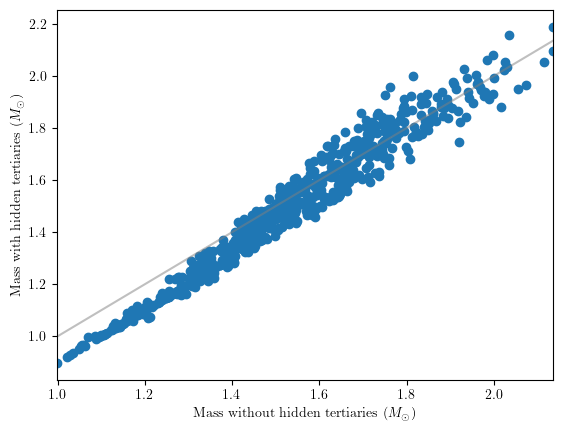

In [497]:
plt.scatter(new_binary_dataframe["M"], new_binary_dataframe["M_tertiaries"])
plt.xlabel(r"Mass without hidden tertiaries ($M_\odot$)")
_=plt.ylabel(r"Mass with hidden tertiaries ($M_\odot$)")
plt.xlim(np.min(new_binary_dataframe["M"]),np.max(new_binary_dataframe["M"]))
x = np.linspace(np.min(new_binary_dataframe["M"]),np.max(new_binary_dataframe["M"]),1000)
plt.plot(x,x,alpha=0.5, color="gray")

7. We now compute the mock 2D velocity using the definitions of $\tilde{v}$ and the distributions for $\phi$, $\phi_0$, $i$ and $e$ for the wide binaries' orbits.

In [498]:
thermal = Thermal()
new_binary_dataframe["eccentricity"] = new_binary_dataframe.apply(lambda x: thermal.random_sample(0,1,size=1)[0], axis=1)

sine = Sine()
new_binary_dataframe["i_angle"] = new_binary_dataframe.apply(lambda x: sine.random_sample(0,np.pi/2,size=1)[0], axis=1)

uniform = Uniform()
new_binary_dataframe["phi_0"] = new_binary_dataframe.apply(lambda x: uniform.random_sample(0,2*np.pi,size=1)[0], axis=1)

def phi_angle(e):
    phi = PhiAngle(
        dist_parameters={
            "e": e,
        }
    )
    return phi.random_sample(0,2*np.pi, size=1)[0]
new_binary_dataframe["phi"] = new_binary_dataframe.apply(lambda x: phi_angle([x.eccentricity]), axis=1)

new_binary_dataframe["psi"] = new_binary_dataframe.apply(lambda x: np.arctan(-(np.cos(x.phi) + x.eccentricity*np.cos(x.phi_0))/(np.sin(x.phi) + x.eccentricity*np.sin(x.phi_0))), axis=1)

v_tilde = VelTilde()
new_binary_dataframe["v_tilde"] = new_binary_dataframe.apply(lambda x: v_tilde.distribution(x.phi, x.phi_0, x.i_angle, x.eccentricity), axis=1)

8. Visualization of `'v_tilde'`

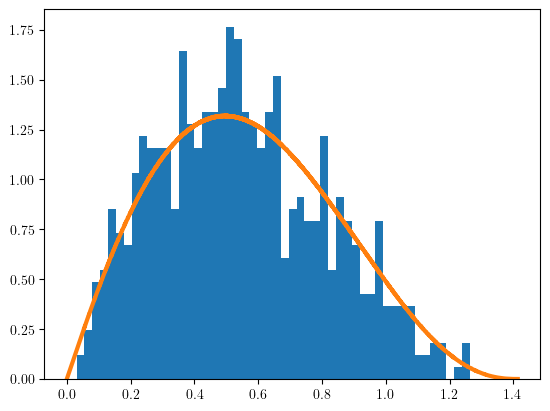

In [499]:
## Extract data with the high resolution \tilde{v} distribution
with open("../data/VTil.dat","r") as file:
    lines = file.readlines()
    
    v = []
    v_dist = []
    for line in lines:
        vel, dist = line.strip().split(" ")
        v.append(float(vel))
        v_dist.append(float(dist))
_=plt.hist(new_binary_dataframe["v_tilde"], bins=50, density=True)
plt.plot(v, v_dist, linewidth=3)         

9. We now compute two values of the 2D relative velocity with and without considering the hidden tertiaries masses.

In [500]:
G = 4.3009e-03 # pc·(km/s)²·M_\odot⁻¹
def get_v2D(mass, separation, v_tilde):
    return np.sqrt(G*mass/separation)*v_tilde

new_binary_dataframe["v2D"] = new_binary_dataframe.apply(lambda x: get_v2D(x.M,x.r,x.v_tilde), axis=1)
new_binary_dataframe["v2D_tertiaries"] = new_binary_dataframe.apply(lambda x: get_v2D(x.M_tertiaries,x.r,x.v_tilde), axis=1)
new_binary_dataframe["v3D_tertiaries"] = new_binary_dataframe.apply(lambda x: x.v2D_tertiaries/np.sqrt(np.cos(x.psi)**2 + (np.cos(x.i_angle)**2)*(np.sin(x.psi)**2)), axis=1)
new_binary_dataframe["v2D_tertiaries_x"] = new_binary_dataframe.apply(lambda x: -x.v3D_tertiaries*np.sin(x.phi), axis=1)
new_binary_dataframe["v2D_tertiaries_y"] = new_binary_dataframe.apply(lambda x: x.v3D_tertiaries*np.cos(x.phi)*np.cos(x.i_angle), axis=1)
new_binary_dataframe["v2D_tertiaries_comp"] = new_binary_dataframe.apply(lambda x: np.sqrt(x.v2D_tertiaries_x**2 + x.v2D_tertiaries_y**2), axis=1)

10. Visualization to compare the real measured `'V2D'` with the mock values and the mass difference between with and without hidden companions

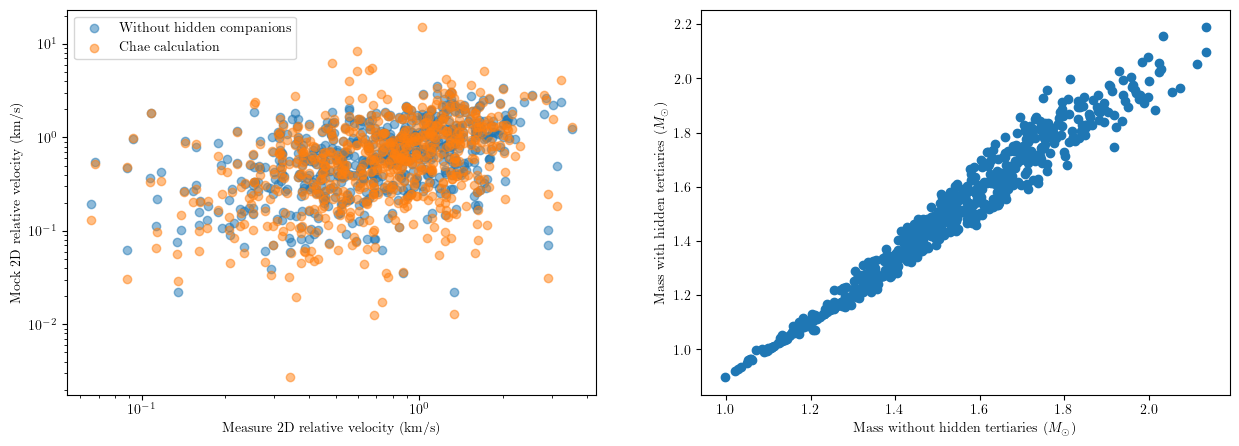

In [501]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(new_binary_dataframe["V2D"], new_binary_dataframe["v2D"], label="Without hidden companions", alpha=0.5)
#ax[0].scatter(new_binary_dataframe["V2D"], new_binary_dataframe["v2D_tertiaries"], label="With hidden companions", alpha=0.5)
ax[0].scatter(new_binary_dataframe["V2D"], new_binary_dataframe["v2D_tertiaries_comp"], label="Chae calculation", alpha=0.5)
ax[1].scatter(new_binary_dataframe["M"], new_binary_dataframe["M_tertiaries"])
ax[0].set_xlabel("Measure 2D relative velocity (km/s)")
ax[0].set_ylabel("Mock 2D relative velocity (km/s)")
ax[1].set_xlabel("Mass without hidden tertiaries ($M_\odot$)")
ax[1].set_ylabel("Mass with hidden tertiaries ($M_\odot$)")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend()

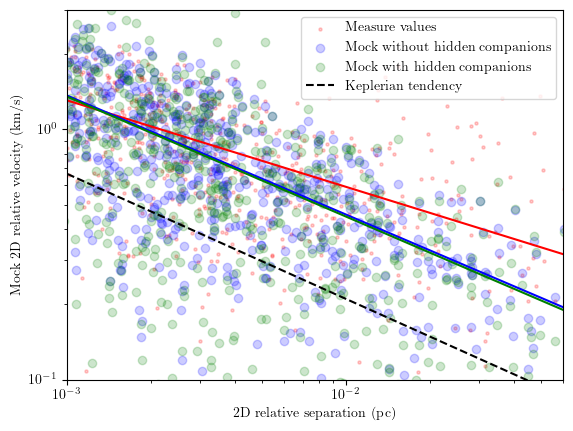

In [502]:
fig, ax = plt.subplots()
ax.scatter(new_binary_dataframe["r"], new_binary_dataframe["V2D"], label="Measure values", alpha=0.2, s=5, color="red")
ax.scatter(new_binary_dataframe["r"], new_binary_dataframe["v2D"], label="Mock without hidden companions", alpha=0.2, color="blue")
ax.scatter(new_binary_dataframe["r"], new_binary_dataframe["v2D_tertiaries_comp"], label="Mock with hidden companions", alpha=0.2, color="green")
ax.set_xlabel("2D relative separation (pc)")
ax.set_ylabel("Mock 2D relative velocity (km/s)")
plt.xscale("log")
plt.yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
x = np.linspace(0.001,6e-2,1000)
ax.plot(x, 0.021*x**(-0.5), label="Keplerian tendency", color="black", linestyle="dashed")
ax.legend()

params, params_covariance = curve_fit(power_law, new_binary_dataframe["r"], new_binary_dataframe["V2D"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="red")

params, params_covariance = curve_fit(power_law, new_binary_dataframe["r"], new_binary_dataframe["v2D"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="blue")

params, params_covariance = curve_fit(power_law, new_binary_dataframe["r"], new_binary_dataframe["v2D_tertiaries"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="green")

11. We now perform the same orbit parameters computation but for each of the inner-hidden orbits per component.

In [503]:
thermal = Thermal()
new_binary_dataframe["eccentricity_A"] = new_binary_dataframe.apply(lambda x: thermal.random_sample(0,1,size=1)[0], axis=1)
new_binary_dataframe["eccentricity_B"] = new_binary_dataframe.apply(lambda x: thermal.random_sample(0,1,size=1)[0], axis=1)

sine = Sine()
new_binary_dataframe["i_angle_A"] = new_binary_dataframe.apply(lambda x: sine.random_sample(0,np.pi/2,size=1)[0], axis=1)
new_binary_dataframe["i_angle_B"] = new_binary_dataframe.apply(lambda x: sine.random_sample(0,np.pi/2,size=1)[0], axis=1)

uniform = Uniform()
new_binary_dataframe["phi_0_A"] = new_binary_dataframe.apply(lambda x: uniform.random_sample(0,2*np.pi,size=1)[0], axis=1)
new_binary_dataframe["phi_0_B"] = new_binary_dataframe.apply(lambda x: uniform.random_sample(0,2*np.pi,size=1)[0], axis=1)

def phi_angle(e):
    phi = PhiAngle(
        dist_parameters={
            "e": e,
        }
    )
    return phi.random_sample(0,2*np.pi, size=1)[0]
new_binary_dataframe["phi_A"] = new_binary_dataframe.apply(lambda x: phi_angle([x.eccentricity_A]), axis=1)
new_binary_dataframe["phi_B"] = new_binary_dataframe.apply(lambda x: phi_angle([x.eccentricity_B]), axis=1)

new_binary_dataframe["psi_A"] = new_binary_dataframe.apply(lambda x: np.arctan(-(np.cos(x.phi_A) + x.eccentricity_A*np.cos(x.phi_0_A))/(np.sin(x.phi_A) + x.eccentricity_A*np.sin(x.phi_0_A))), axis=1)
new_binary_dataframe["psi_B"] = new_binary_dataframe.apply(lambda x: np.arctan(-(np.cos(x.phi_B) + x.eccentricity_B*np.cos(x.phi_0_B))/(np.sin(x.phi_B) + x.eccentricity_B*np.sin(x.phi_0_B))), axis=1)

v_tilde = VelTilde()
new_binary_dataframe["v_tilde_A"] = new_binary_dataframe.apply(lambda x: v_tilde.distribution(x.phi_A, x.phi_0_A, x.i_angle_A, x.eccentricity_A), axis=1)
new_binary_dataframe["v_tilde_B"] = new_binary_dataframe.apply(lambda x: v_tilde.distribution(x.phi_B, x.phi_0_B, x.i_angle_B, x.eccentricity_B), axis=1)

12. We compute the inner-hidden orbit separation by assuming a log distribution for the semi-major axis $a_{in}$.

In [534]:
log = Log()

def get_semi_major_axis(parallax, inner_binary_mass):
    ua = 4.84e-6
    
    a_in = log.random_sample(0.01, parallax, size=1)[0] # in UA
    P = np.sqrt(a_in**3/(inner_binary_mass))
    while P < 3:
        a_in = log.random_sample(0.01, parallax, size=1)[0] # in UA
        P = np.sqrt(a_in**3/(inner_binary_mass))
    return a_in * ua
        
new_binary_dataframe["a_in_A"] = new_binary_dataframe.apply(lambda x: get_semi_major_axis(x.PARALLAX1, x.M_A), axis=1)
new_binary_dataframe["a_in_B"] = new_binary_dataframe.apply(lambda x: get_semi_major_axis(x.PARALLAX2, x.M_B), axis=1)

13. From $a_{in}$ we compute the 3D separation $r_{in}$ following Chae 2023

In [522]:
new_binary_dataframe["r_3D_in_A"] = new_binary_dataframe.apply(lambda x: x.a_in_A*(1 - x.eccentricity_A**2)/(1 + x.eccentricity_A*np.cos(x.phi_A - x.phi_0_A)), axis=1)
new_binary_dataframe["r_3D_in_B"] = new_binary_dataframe.apply(lambda x: x.a_in_B*(1 - x.eccentricity_B**2)/(1 + x.eccentricity_B*np.cos(x.phi_B - x.phi_0_B)), axis=1)

14. And finally we get the 2D projected separation $s_{in}$ as:

In [523]:
new_binary_dataframe["s_A"] = new_binary_dataframe.apply(lambda x: x.r_3D_in_A*np.sqrt(np.cos(x.phi_A)**2 + (np.sin(x.phi_A)**2)*np.cos(x.i_angle_A)**2), axis=1)
new_binary_dataframe["s_B"] = new_binary_dataframe.apply(lambda x: x.r_3D_in_B*np.sqrt(np.cos(x.phi_B)**2 + (np.sin(x.phi_B)**2)*np.cos(x.i_angle_B)**2), axis=1)

15. Now we compute the 2D projected relative velocity from the inner-hidden orbits

In [524]:
alp=3.5
new_binary_dataframe["eta_phot_A"] = new_binary_dataframe.apply(lambda x: x.mass_A_1*x.mass_A_2*(x.mass_A_1**(alp-1)-x.mass_A_2**(alp-1))/((x.mass_A_1+x.mass_A_2)*(x.mass_A_1**alp+x.mass_A_2**alp)), axis=1)
new_binary_dataframe["eta_phot_B"] = new_binary_dataframe.apply(lambda x: x.mass_B_1*x.mass_B_2*(x.mass_B_1**(alp-1)-x.mass_B_2**(alp-1))/((x.mass_B_1+x.mass_B_2)*(x.mass_B_1**alp+x.mass_B_2**alp)), axis=1)

In [525]:
G = 4.3009e-03 # pc·(km/s)²·M_\odot⁻¹
new_binary_dataframe["v2D_A"] = new_binary_dataframe.apply(lambda x: np.sqrt(G*x.M_A/x.s_A)*x.v_tilde_A, axis=1)#*np.sqrt(2 - x.r_3D_in_A/x.a_in_A),axis=1)#*x.v_tilde_A, axis=1)
new_binary_dataframe["v2D_B"] = new_binary_dataframe.apply(lambda x: np.sqrt(G*x.M_B/x.s_B)*x.v_tilde_B, axis=1)#*np.sqrt(2 - x.r_3D_in_B/x.a_in_B),axis=1)#*x.v_tilde_B, axis=1)

new_binary_dataframe["v3D_A"] = new_binary_dataframe.apply(lambda x: x.v2D_A/np.sqrt(np.cos(x.psi_A)**2 + (np.cos(x.i_angle_A)**2)*(np.sin(x.psi_A)**2)), axis=1)
new_binary_dataframe["v3D_B"] = new_binary_dataframe.apply(lambda x: x.v2D_B/np.sqrt(np.cos(x.psi_B)**2 + (np.cos(x.i_angle_B)**2)*(np.sin(x.psi_B)**2)), axis=1)

new_binary_dataframe["v2D_A_x"] = new_binary_dataframe.apply(lambda x: -x.v3D_A*np.sin(x.phi_A), axis=1)
new_binary_dataframe["v2D_A_y"] = new_binary_dataframe.apply(lambda x: x.v3D_A*np.cos(x.phi_A)*np.cos(x.i_angle_A), axis=1)

new_binary_dataframe["v2D_B_x"] = new_binary_dataframe.apply(lambda x: -x.v3D_B*np.sin(x.phi_B), axis=1)
new_binary_dataframe["v2D_B_y"] = new_binary_dataframe.apply(lambda x: x.v3D_B*np.cos(x.phi_B)*np.cos(x.i_angle_B), axis=1)

In [526]:
new_binary_dataframe["full_v2D_tertiaries_x"] = new_binary_dataframe.apply(lambda x: x.v2D_tertiaries_x + x.eta_phot_A*x.v2D_A_x + x.eta_phot_B*x.v2D_B_x, axis=1)
new_binary_dataframe["full_v2D_tertiaries_y"] = new_binary_dataframe.apply(lambda x: x.v2D_tertiaries_y + x.eta_phot_A*x.v2D_A_y + x.eta_phot_B*x.v2D_B_y, axis=1)
new_binary_dataframe["full_v2D_tertiaries"] = new_binary_dataframe.apply(lambda x: np.sqrt(x.full_v2D_tertiaries_x**2 + x.full_v2D_tertiaries_y**2), axis=1)
new_binary_dataframe["full_v_tilde_tertiaries"] = new_binary_dataframe.apply(lambda x: x.full_v2D_tertiaries/np.sqrt(G*x.M_tertiaries/x.r), axis=1)

16. Add error to `full_v2D_tertiaries` 

In [527]:
new_binary_dataframe["full_v2D_tertiaries_and_error"] = new_binary_dataframe.apply(lambda x: x.full_v2D_tertiaries + np.random.normal(0.0, x.d_V2D), axis=1)

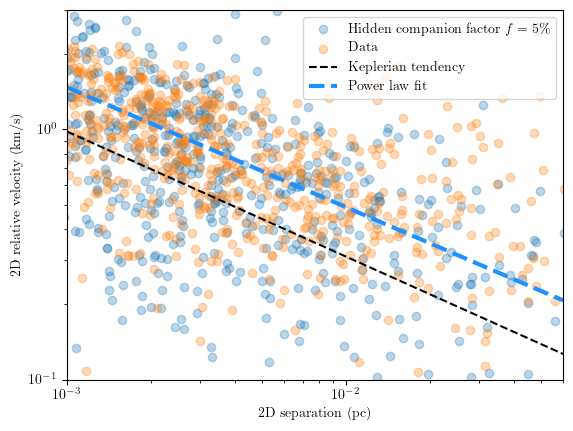

In [528]:
fig, ax = plt.subplots()
ax.scatter(new_binary_dataframe["r"], new_binary_dataframe["full_v2D_tertiaries_and_error"], alpha=0.3, label=f"Hidden companion factor $f = {f*100:.0f}$\%")
ax.scatter(new_binary_dataframe["r"], new_binary_dataframe["V2D"], alpha=0.3, label="Data")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")

x = np.linspace(0.001,6e-2,1000)
ax.plot(x, 0.031*x**(-0.5), label="Keplerian tendency", color="black", linestyle="dashed")

params, params_covariance = curve_fit(power_law, new_binary_dataframe["r"], new_binary_dataframe["full_v2D_tertiaries_and_error"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="dodgerblue", linewidth=3, linestyle="dashed", label="Power law fit")

ax.legend()

In [529]:
new_binary_dataframe.columns

Index(['Unnamed: 0', 'SOURCE_ID_PRIMARY', 'ra1', 'dec1', 'mag1', 'MAG1',
       'PARALLAX1', 'parallax_error1', 'DIST1', 'RUWE1',
       ...
       'v3D_B', 'v2D_A_x', 'v2D_A_y', 'v2D_B_x', 'v2D_B_y',
       'full_v2D_tertiaries_x', 'full_v2D_tertiaries_y', 'full_v2D_tertiaries',
       'full_v_tilde_tertiaries', 'full_v2D_tertiaries_and_error'],
      dtype='object', length=111)

In [530]:
hist, bins = np.histogram(new_binary_dataframe["r"], bins=[0.0001, 0.001, 0.002, 0.0045, 0.01, 0.025, 0.06])

bines = []
bines_tilde = []
bines_std = []
for index, bin_ in enumerate(bins[1:]):
    mask = new_binary_dataframe.loc[(new_binary_dataframe['r'] >= bins[index-1]) & (new_binary_dataframe['r'] < bins[index]), 'full_v2D_tertiaries_and_error'].copy()
    bines.append(mask)
    mask = new_binary_dataframe.loc[(new_binary_dataframe['r'] >= bins[index-1]) & (new_binary_dataframe['r'] < bins[index]), 'full_v_tilde_tertiaries'].copy()
    bines_tilde.append(mask)
    mask = new_binary_dataframe.loc[(new_binary_dataframe['r'] >= bins[index-1]) & (new_binary_dataframe['r'] < bins[index]), 'd_V2D'].copy()
    bines_std.append(mask)

mean = []
median = []
rms = []
for vel_bins in bines:
    mean.append(np.nanmean(vel_bins))
    median.append(np.nanmedian(vel_bins))
    rms.append(np.sqrt(np.nanmean(vel_bins**2)))

/tmp/ipykernel_211887/4084555657.py:18: RuntimeWarning: Mean of empty slice
  mean.append(np.nanmean(vel_bins))
/home/aaguayoo/.cache/pypoetry/virtualenvs/binaries-statistics-38ZGLDxd-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_211887/4084555657.py:20: RuntimeWarning: Mean of empty slice
  rms.append(np.sqrt(np.nanmean(vel_bins**2)))


/home/aaguayoo/.cache/pypoetry/virtualenvs/binaries-statistics-38ZGLDxd-py3.10/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


(0.0, 1.4142135623730951)

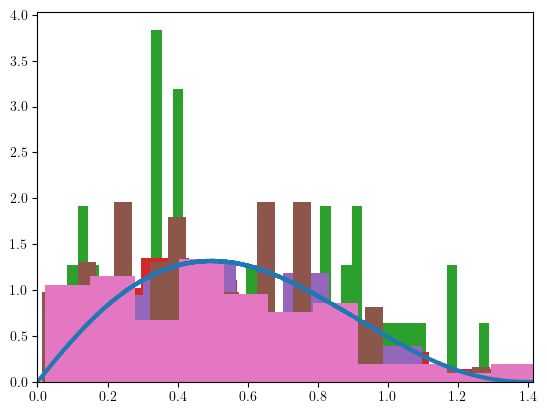

In [531]:
with open("../data/VTil.dat","r") as file:
    lines = file.readlines()
    
    v = []
    v_dist = []
    for line in lines:
        vel, dist = line.strip().split(" ")
        v.append(float(vel))
        v_dist.append(float(dist))
plt.plot(v, v_dist, linewidth=3)   
for bin_tilde in bines_tilde:
    plt.hist(bin_tilde, bins=50, density=True)
plt.xlim(0,np.sqrt(2))

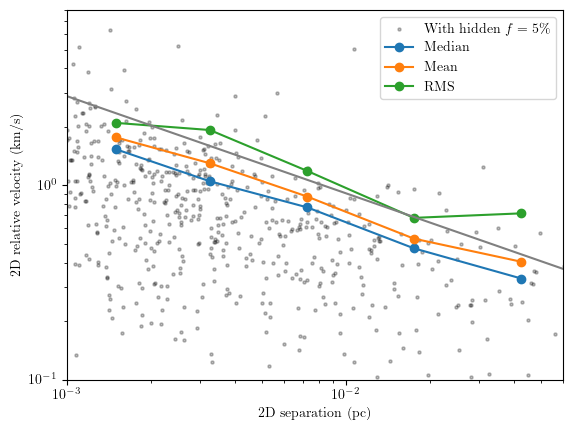

In [532]:
fig, ax = plt.subplots()
ax.scatter(new_binary_dataframe["r"],new_binary_dataframe["full_v2D_tertiaries_and_error"], s=5, alpha=0.25, label = f"With hidden $f={f*100:.0f}$\%", color="black")

bin_center = (bins[1:] + bins[:-1])/2

ax.plot(bin_center, median, label="Median", marker="o")
ax.plot(bin_center, mean, label="Mean", marker="o")
ax.plot(bin_center, rms, label="RMS", marker="o")
    
x = np.linspace(0.001,6e-2,1000)
ax.plot(x, 0.091*x**(-0.5), color="gray")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")
ax.set_xlim(0.001,6e-2)
ax.set_ylim(0.1,8)
ax.legend()

- Possible changes:
    - Add the hidden tertiaries velocity by component as Chae 2023 does for the proper motion.

(array([0.73094552, 0.45684095, 1.00505009, 1.27915466, 0.45684095,
        1.46189103, 1.00505009, 0.36547276, 1.18778647, 0.73094552,
        0.9136819 , 1.55325922, 1.46189103, 1.55325922, 1.27915466,
        1.00505009, 0.9136819 , 1.27915466, 1.09641828, 1.09641828,
        0.82231371, 0.73094552, 0.9136819 , 0.82231371, 0.36547276,
        0.36547276, 1.64462741, 0.9136819 , 1.18778647, 0.73094552,
        0.63957733, 1.00505009, 0.73094552, 0.36547276, 0.45684095,
        0.27410457, 0.45684095, 0.45684095, 0.36547276, 0.27410457,
        0.09136819, 0.36547276, 0.09136819, 0.09136819, 0.        ,
        0.18273638, 0.09136819, 0.09136819, 0.        , 0.09136819,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.09136819, 0.09136819, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09136819, 0.        ,
        0.        , 0.18273638, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

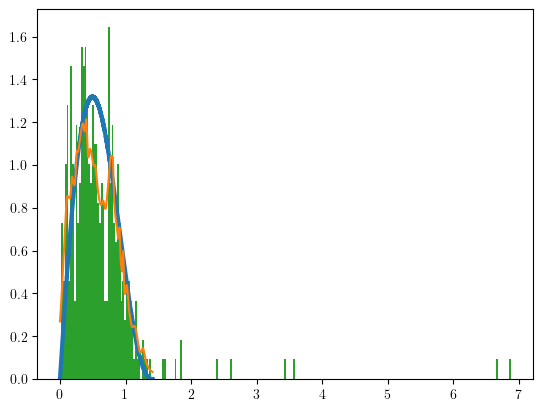

In [533]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

with open("../data/VTil.dat","r") as file:
    lines = file.readlines()
    
    v = []
    v_dist = []
    for line in lines:
        vel, dist = line.strip().split(" ")
        v.append(float(vel))
        v_dist.append(float(dist))
plt.plot(v, v_dist, linewidth=3)    

# Datos de las distribuciones gaussianas
index = 1
medias = list(bines_tilde[index]) + list(bines_tilde[2]) + list(bines_tilde[3])
desviaciones_estandar = list(bines_std[index]) + list(bines_std[2]) + list(bines_std[3])

# Crear un rango de valores para la variable aleatoria
x = np.linspace(0, np.sqrt(2), 1000)

# Inicializar la PDF total como una distribución normal con media y desviación estándar cero
pdf_total = norm.pdf(x, loc=medias[0], scale=desviaciones_estandar[0])

# Calcular la PDF de la suma de las distribuciones gaussianas
for media, desviacion in zip(medias[1:], desviaciones_estandar[1:]):
    pdf_total += norm.pdf(x, loc=media, scale=desviacion)

# Normalizar la PDF total dividiendo por el número de distribuciones
pdf_total /= len(medias) + 1

# Graficar la PDF total
plt.plot(x, pdf_total, label='PDF Total')
plt.hist(medias, density=True, bins=250)

#plt.xlim(0, 4)